In [1]:
import numpy as np
from scipy.linalg import eig, eig_banded, eigh
from scipy.sparse.linalg import eigs, eigsh
from scipy.sparse import eye, diags
import kwant
from scipy.integrate import quad


import matplotlib.pyplot as plt

In [2]:
%%time
# N = 5000
# eps = 0.1
# a = 0.1

# c = np.random.rand(N-1) + np.random.rand(N-1)*1j
# b = np.random.rand(N)
# H = diags(c, offsets=-1) + diags(b, offsets=0) + diags(c.conj(), offsets=1)
# Emin = eigsh(H, k=1, which='SA', return_eigenvectors=False)[0]
# Emax = eigsh(H, k=1, which='LA', return_eigenvectors=False)[0]
# E_max_abs = np.max(np.abs([Emax, Emin]))


N = 500
eps = 0.1
a = 0.4

b = np.concatenate((np.ones(int(N/4))*-1, np.ones(int(N/2))*0.1, np.ones(int(N/4))*1))
H = diags(b, offsets=0)
Emin = eigsh(H, k=1, which='SA', return_eigenvectors=False)[0]
Emax = eigsh(H, k=1, which='LA', return_eigenvectors=False)[0]
E_max_abs = np.max(np.abs([Emax, Emin]))


def G_operator(ham, Emax, Emin):
    Emax=Emax*(1 + eps)
    Emin=Emin*(1 + eps)
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax*(1 + eps)
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0])*Ec)/E0

G = G_operator(H, Emax, Emin)
F = F_operator(H, E_max_abs, a)
a_r = a/E_max_abs


dos_estimate = kwant.kpm.SpectralDensity(
    H,
    energy_resolution=2*a,
    mean=True,
    bounds=(Emin, Emax)
)

d=int(np.abs(dos_estimate(0)*2*a))
d


CPU times: user 19.8 ms, sys: 2.11 ms, total: 21.9 ms
Wall time: 19.6 ms


126

In [3]:
def low_E_filter(v_rand, matrix, k):
    for i in range(k+1):
        if i == 0:
            v_n = v_rand
            continue

        elif i == 1:
            v_nm1 = v_n
            v_n = matrix @ v_nm1
            continue
        else:
            v_np1 = 2*matrix @ v_n - v_nm1
            v_nm1 = v_n
            v_n = v_np1
    return v_n/np.linalg.norm(v_n)

def basis(v_proj, matrix, indices):
    v_basis = []
    # TODO: If k is too large, the norms of the vectors are from some large order.
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            v_n = v_proj
            continue
        elif i == 1:
            v_nm1 = v_n
            v_n = matrix @ v_nm1
            continue
        else:
            v_np1 = 2 * matrix @ v_n - v_nm1
            v_nm1 = v_n
            v_n = v_np1
        if i in indices:
            v_basis.append(v_n / np.linalg.norm(v_n))
    return np.asarray(v_basis)

CPU times: user 84.1 ms, sys: 19.3 ms, total: 103 ms
Wall time: 103 ms


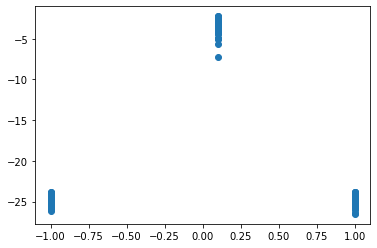

In [4]:
%%time
true_eigvals, true_eigvecs = eigh(H.todense())


ψ_rand = 2 * (np.random.rand(N) + np.random.rand(N)*1j - 0.5 * (1 + 1j))
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12*E_max_abs/a))

plt.scatter(np.real(true_eigvals), np.log(np.abs(true_eigvecs.T.conj()@ψ_proj)))
#plt.xlim([-a-a/2, a+a/2])

In [7]:
%%time
n = int((d*3 - 1)/2)
n_array = np.arange(1, n+1, 1)
indicesp1 = (n_array*np.pi/a_r).astype(int)
indices = np.sort(np.array([*indicesp1, *indicesp1-1]))

ψ_basis = basis(ψ_proj, G, indices)

def gram_schmidt(A):
    """Orthogonalize a set of vectors stored as the columns of matrix A."""
    # Get the number of vectors.
    n = A.shape[1]
    for j in range(n):
        # To orthogonalize the vector in column j with respect to the
        # previous vectors, subtract from it its projection onto
        # each of the previous vectors.
        for k in range(j):
            A[:, j] -= np.dot(A[:, k], A[:, j]) * A[:, k]
        A[:, j] = A[:, j] / np.linalg.norm(A[:, j])
    return A


ψ_basis = gram_schmidt(ψ_basis)

CPU times: user 1.55 s, sys: 5.39 ms, total: 1.56 s
Wall time: 1.55 s


In [8]:
np.shape(ψ_basis)

(376, 500)

In [9]:
np.shape(indices)

(376,)

In [12]:
%%time
S = ψ_basis.conj()@ψ_basis.T
H_proj = ψ_basis.conj()@H@ψ_basis.T

CPU times: user 60.2 ms, sys: 11.2 ms, total: 71.4 ms
Wall time: 67.8 ms


In [45]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 307 ms, sys: 5.99 ms, total: 313 ms
Wall time: 307 ms


In [44]:
np.shape(H_proj_red)

(3, 3)

In [40]:
%%time
# could use eigh, H_proj_red is approximately hermitian
eigvalues, eigvectors = eigh(H_proj_red)

CPU times: user 486 µs, sys: 0 ns, total: 486 µs
Wall time: 406 µs


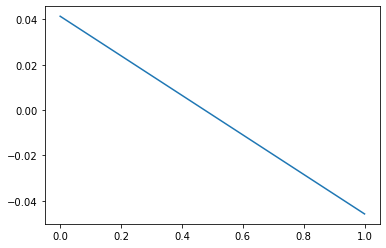

In [41]:
plt.plot(np.log10(np.diff(np.sort(np.real(eigvalues)))))

(0.0, 0.2)

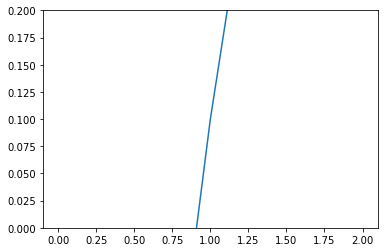

In [42]:
plt.plot(np.sort(np.real(eigvalues)))
plt.ylim([0, 0.2])

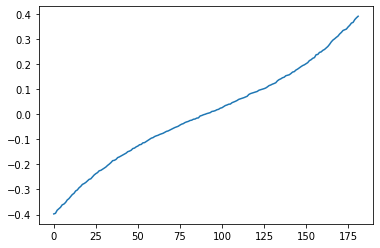

In [34]:
out_indx = a >= np.abs(eigvalues)
plt.plot(np.sort(np.real(eigvalues[out_indx])))